In [1]:
import os
import numpy as np
import lxml
from lxml import objectify, etree, html
import json
import urllib3
from io import StringIO, BytesIO
import newspaper
from newspaper import Article
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from scipy.sparse import *
import enchant
import stop_words
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer

%matplotlib inline

In [ ]:
cnn_paper = newspaper.build('http://cnn.com')
for article in cnn_paper.articles:
    print(article.url)

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


In [3]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u2066', 'à', '½', '£','\u2069', '–', '©', '⅔'])

regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [4]:
sport =  np.load("sport.npy")
asia =  np.load("asia.npy")
travel =  np.load("travel.npy")
health =  np.load("health.npy") 

In [5]:
flags = np.concatenate((np.full(len(sport), 'sport'), np.full(len(asia), 'asia'), np.full(len(travel), 'travel'),
                      np.full(len(health), 'health')))
df = pd.DataFrame({'text': np.concatenate((sport, asia, travel, health)), 'category': flags})
df.head()


,text,category
0,Atlanta (CNN) Here's one that's not seen or he...,sport
1,"(CNN) Speaking to reporters last week, Bill Be...",sport
2,Patriots safety Duron Harmon was seen playing ...,sport
3,Photos: What a shot! 25 amazing sports photos ...,sport
4,Story highlights Fiji 38-0 USA in Hamilton Sev...,sport


In [12]:
df.shape

(298, 2)

In [10]:
pd.to_pickle(df,"df")

In [11]:
pd.read_pickle("df")

,text,category
0,Atlanta (CNN) Here's one that's not seen or he...,sport
1,"(CNN) Speaking to reporters last week, Bill Be...",sport
2,Patriots safety Duron Harmon was seen playing ...,sport
3,Photos: What a shot! 25 amazing sports photos ...,sport
4,Story highlights Fiji 38-0 USA in Hamilton Sev...,sport
5,(CNN) Combining the very best thoroughbreds ho...,sport
6,"(CNN) Hearts thumping under thin race suits, e...",sport
7,"(CNN) Horse racing may be the sport of kings, ...",sport
8,This merry band of Swiss ski racing fans draws...,sport
9,(CNN) Norwegian skier Aksel Lund Svindal is to...,sport


In [9]:
text_array = np.concatenate((sport, asia, travel, health))
np.save("corpus_arr", text_array)

In [7]:
doc= sport[1:6]
text1=[]
for sptext in text_array:    
    sptext = re.sub(r'(\n)+', ' ', sptext)
    sptext = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sptext)
    sptext = emoji_pattern.sub('', sptext)
    sptext = regex_punct.sub(' ', sptext)
    sptext = regex_symb.sub('', sptext)
    sptext = regex_dig.sub('', sptext)
    sptext = re.sub(r'( )( )+', ' ', sptext)
    sptext = sptext.lower()
    text1.append(sptext)

In [95]:
sport[1]

'(CNN) Speaking to reporters last week, Bill Belichick was asked if he\'s gotten to know his Super Bowl LIII opponent, Rams head coach Sean McVay.\n\n"Yeah, I know him," the 66-year-old Patriots head coach said, which is about the extent of acknowledgment many have come to expect from the man who doesn\'t give much away.\n\nBut McVay clearly has the attention of Belichick (more on that later), who has the most Super Bowl titles (five) of all time, as well as the rest of the NFL.\n\nThis will be Belichick\'s ninth Super Bowl appearance. It\'s the first for McVay, who, at 33, is the youngest coach in Super Bowl history.\n\nAnd he is viewed as the NFL\'s next prodigy.\n\n"Working with him, man, it\'s a good feeling just to have him as our coach," Rams running back Todd Gurley said. "He\'s a players\' coach. He\'s a great guy. You can talk to him, you can understand and he does everything for a reason. He does everything for us, for the team. So, you love playing for a guy like that."\n\nM

In [96]:
sport1[1]

' cnn speaking to reporters last week bill belichick was asked if he s gotten to know his super bowl liii opponent rams head coach sean mcvay yeah i know him the year old patriots head coach said which is about the extent of acknowledgment many have come to expect from the man who doesn t give much away but mcvay clearly has the attention of belichick more on that later who has the most super bowl titles five of all time as well as the rest of the nfl this will be belichick s ninth super bowl appearance it s the first for mcvay who at is the youngest coach in super bowl history and he is viewed as the nfl s next prodigy working with him man it s a good feeling just to have him as our coach rams running back todd gurley said he s a players coach he s a great guy you can talk to him you can understand and he does everything for a reason he does everything for us for the team so you love playing for a guy like that mcvay with gerald everett after defeating the new orleans saints in the nf

In [8]:
morph = pymorphy2.MorphAnalyzer()
morph.word_is_known('деревом')

NameError: name 'pymorphy2' is not defined

In [39]:
dict_en.check('\u2066')

True

In [9]:
dict_en = enchant.Dict('en_EN')
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(text1[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('en') and word not in ['s', 't', 'd', 'v', 've', 'll', 're']:
            if dict_en.check(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens))

298


In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
wnl = WordNetLemmatizer()

In [11]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
stemmer.stem('playing')

'play'

In [12]:
corpus_tokens_lem=[]
for i, tokens in enumerate(log_progress(corpus_tokens)):
    tmp_tokens = []
    for word in tokens:
        tmp_word = wnl.lemmatize(word)
        tmp_word = stemmer.stem(tmp_word)
        tmp_tokens.append(tmp_word)
    corpus_tokens_lem.append(tmp_tokens)
print(len(corpus_tokens_lem), len(text1))

298 298


In [56]:
wnl.lemmatize('mice')

'mouse'

In [57]:
stemmer.stem('mouse')

'mous'

In [23]:
np.save('stemmed', corpus_tokens_lem)

In [42]:
np.transpose(corpus_tokens_lem[1])

array(['speak', 'report', 'last', 'week', 'bill', 'ask', 'gotten', 'know',
       'super', 'bowl', 'oppon', 'ram', 'head', 'coach', 'yeah', 'know',
       'year', 'old', 'patriot', 'head', 'coach', 'said', 'extent',
       'acknowledg', 'mani', 'come', 'expect', 'man', 'give', 'much',
       'away', 'clear', 'attent', 'later', 'super', 'bowl', 'titl',
       'five', 'time', 'well', 'rest', 'will', 'ninth', 'super', 'bowl',
       'appear', 'first', 'youngest', 'coach', 'super', 'bowl', 'histori',
       'view', 'next', 'prodigi', 'work', 'man', 'good', 'feel', 'just',
       'coach', 'ram', 'run', 'back', 'said', 'player', 'coach', 'great',
       'guy', 'can', 'talk', 'can', 'understand', 'everyth', 'reason',
       'everyth', 'u', 'team', 'love', 'play', 'guy', 'like', 'defeat',
       'new', 'saint', 'championship', 'game', 'new', 'histor', 'hire',
       'ram', 'announc', 'next', 'head', 'footbal', 'coach', 'just',
       'hire', 'reveal', 'choic', 'sent', 'throughout', 'leagu', 'y

In [43]:
np.transpose(corpus_tokens[1])

array(['speaking', 'reporters', 'last', 'week', 'bill', 'asked', 'gotten',
       'know', 'super', 'bowl', 'opponent', 'rams', 'head', 'coach',
       'yeah', 'know', 'year', 'old', 'patriots', 'head', 'coach', 'said',
       'extent', 'acknowledgment', 'many', 'come', 'expect', 'man',
       'give', 'much', 'away', 'clearly', 'attention', 'later', 'super',
       'bowl', 'titles', 'five', 'time', 'well', 'rest', 'will', 'ninth',
       'super', 'bowl', 'appearance', 'first', 'youngest', 'coach',
       'super', 'bowl', 'history', 'viewed', 'next', 'prodigy', 'working',
       'man', 'good', 'feeling', 'just', 'coach', 'rams', 'running',
       'back', 'said', 'players', 'coach', 'great', 'guy', 'can', 'talk',
       'can', 'understand', 'everything', 'reason', 'everything', 'us',
       'team', 'love', 'playing', 'guy', 'like', 'defeating', 'new',
       'saints', 'championship', 'game', 'new', 'historic', 'hire',
       'rams', 'announced', 'next', 'head', 'football', 'coach', 'just'

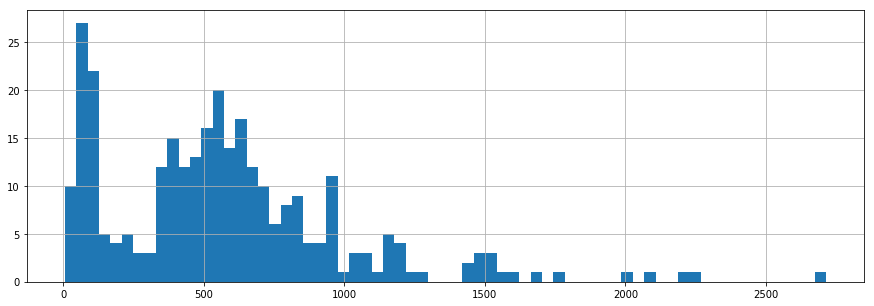

In [54]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_lem])
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=67)
plt.grid(True)

In [55]:
diffs

array([  59,  597,  386,  400,  105,  632,  837,  935,  967,  113,  676,
        816,  965,  683,   61,  867,  950,   54,   59,  480,  622,   92,
         60, 1169,  871, 1555,  784, 1042, 1422, 1169,  532,  659,  539,
        345,  565,  517,  561,  594,  381,  584,   14,  123,   53,  597,
        619,  467,  616,   61,  446,   85,   50,  384,  385,  110,  502,
       1083, 1193,  406,   51,  479,  648,  533,  426,   83,  582,  570,
        384,  122,   94,  439,   67,  710,  104,   74,  466,  441,   49,
        586,  556,   72,  385,   86,  359,  941,   68, 1020,  102,   81,
        107,   72,  368,  568,  968,  503,  471,  680,  407,  262,  784,
        200,  337,  700,  688,  158,  552,   17,  968,  245,  504,  719,
        769,  942,  663, 1190,  653,  300,  465,  126,  278,  548,  393,
         21,  771, 2713,  457,  594,  400,  175,  656,  575,  540,  952,
        826,  599,  439,  349,  797,  520,  221,   64,  762,   14,    7,
         13,    9,  156,  942,   74,  902,  652,  5

In [13]:
sport_vocab = np.unique(np.concatenate(corpus_tokens_lem).flatten()).tolist()
print(len(sport_vocab))

9053


In [14]:
print((sport_vocab))

['aback', 'abandon', 'abbey', 'abdomen', 'abdomin', 'abduct', 'abet', 'abid', 'abil', 'abl', 'ablat', 'ablaz', 'abnorm', 'aboard', 'abolish', 'aborigin', 'abort', 'abound', 'abras', 'abroad', 'abrupt', 'absenc', 'absent', 'absolut', 'absorb', 'absorpt', 'abstain', 'abstin', 'abstract', 'absurd', 'abund', 'abus', 'abut', 'abuzz', 'ac', 'academ', 'academi', 'acceler', 'accept', 'access', 'accid', 'accident', 'acclaim', 'acclim', 'accommod', 'accompani', 'accomplish', 'accord', 'accordion', 'account', 'accru', 'accumul', 'accur', 'accuraci', 'accus', 'accustom', 'ace', 'acet', 'ach', 'achiev', 'acid', 'acknowledg', 'acn', 'acquir', 'acr', 'acronym', 'across', 'act', 'action', 'activ', 'activist', 'actor', 'actress', 'actual', 'acut', 'ad', 'adapt', 'add', 'addict', 'addit', 'address', 'adenocarcinoma', 'adenoid', 'adequ', 'adher', 'adjac', 'adject', 'adjoin', 'adjunct', 'adjust', 'administ', 'administr', 'admir', 'admiss', 'admit', 'adolesc', 'adopt', 'ador', 'adorn', 'adrift', 'adul', 'a

In [15]:
tokens = []
for i, text in enumerate(log_progress(corpus_tokens_lem)):
    tmp_text = []
    for word in text:
        tmp_text.append(sport_vocab.index(word))
    tokens.append(tmp_text)

In [59]:
print(np.transpose(tokens[1]))

[7376 6516 4386 8822  739  427 3396 4332 7748  892 5356 6264 3609 1455
 9015 4332 9016 5326 5606 3609 1455 6772 2797   61 4695 1518 2767 4683
 3328 5053  516 1412  468 4389 7748  892 8096 2986 8079 8835 6557 8902
 5197 7748  892  335 2976 9034 1455 7748  892 3713 8681 5179 6052 8957
 4683 3383 2906 4266 1455 6264 6739  528 6772 5817 1455 3449 3518 1106
 7884 1106 8405 2714 6326 2714 8329 7924 4600 5815 3518 4508 2007 5166
 6775 1256 3252 5166 3712 3711 6264  294 5179 3609 3079 1455 4266 3711
 6599 1340 6963 8047 4419 9016 5326 9034 3609 1455 3713 2101  142  222
 6994 9016 2775 4419    8 6336 5815 2706 5341 9016  150 4911  813 1431
  785 6516 8840 8699 6222 7384 5815 8018 6314 7440  528 6264 4536 6479
 2710 5815 1455 1150 5743 8324 1511  785 6516 6264 6195 4266 6699 6911
 6339 6336 3383 3919 4133 4226 4432 4804 3393 6007 3383 3856 5341 1352
 2738 5251 6772  518 8305 6007 8835 8019 1319 5353 5313 3288 4684 6264
 7508 5727  294 3711 3609 1455 1518 3079 2853  868 7520 4663 1632 9032
  142 

In [60]:
np.save("tokents", tokens)

In [63]:
df_clean = pd.DataFrame({'text': tokens, 'category': flags}) 
np.save("df", df_clean)

In [2]:
df = np.load("df.npy")

In [129]:
're' in sport_vocab

False

In [16]:
def tf(token,text):
    n = text.count(token)
    m = len(text)
    return n/m

def idf(token,texts):
    cnt = 0
    for text in texts:
        if text.count(token)>0:
            cnt+=1
    return np.log(len(texts)/cnt)

def tf_idf(token, text, idfs):
    return tf(token, text)*idfs

#print('TF: {0}, IDF: {1}, TF-IDF: {2}'.format(kek1,kek2,kek1*kek2))

In [19]:
np.save("idfs", idfs)

In [18]:
idfs=[]
for i in range(0, len(sport_vocab)):
    idfs.append(idf(i, tokens)) 

In [21]:
n=len(sport_vocab)
vectorized=[]
for text in tokens:
    vec = []
    for i in range(0, n):
        tfidf = tf_idf(i, text, idfs[i])
        vec.append(tfidf)
    vectorized.append(vec)
len(vectorized)       
        

298

In [22]:
np.save('vectorized', vectorized)

In [167]:
sptext = re.sub(r'(\n)+', ' ', searchstr)
sptext = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sptext)
sptext = emoji_pattern.sub('', sptext)
sptext = regex_punct.sub(' ', sptext)
sptext = regex_symb.sub('', sptext)
sptext = regex_dig.sub('', sptext)
sptext = re.sub(r'( )( )+', ' ', sptext)
searchstr = sptext.lower()
searchstr

'chief operating officer'

In [171]:
tmp_tokens = []
sp = searchstr.split()
for word in sp:
    if word not in stop_words.get_stop_words('en') and word not in ['s', 't', 'd', 'v', 've', 'll', 're']:
        if dict_en.check(word):
            tmp_tokens.append(word)    
tmp_tokens

['chief', 'operating', 'officer']

In [172]:
search_tokens=[]
for word in tmp_tokens:
    tmp_word = wnl.lemmatize(word)
    tmp_word = stemmer.stem(tmp_word)
    search_tokens.append(tmp_word)
search_tokens

['chief', 'oper', 'offic']

In [79]:
def vectorize(searchstr):
    sptext = re.sub(r'(\n)+', ' ', searchstr)
    sptext = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sptext)
    sptext = emoji_pattern.sub('', sptext)
    sptext = regex_punct.sub(' ', sptext)
    sptext = regex_symb.sub('', sptext)
    sptext = regex_dig.sub('', sptext)
    sptext = re.sub(r'( )( )+', ' ', sptext)
    searchstr = sptext.lower()
    tmp_tokens = []
    sp = searchstr.split()
    for word in sp:
        if word not in stop_words.get_stop_words('en') and word not in ['s', 't', 'd', 'v', 've', 'll', 're']:
            if dict_en.check(word):
                tmp_tokens.append(word)  
    search_tokens=[]
    for word in tmp_tokens:
        tmp_word = wnl.lemmatize(word)
        tmp_word = stemmer.stem(tmp_word)
        search_tokens.append(tmp_word)
    
    tmp_text = []
    for word in  search_tokens:
        tmp_text.append(vocab.index(word))
    #print(tmp_text)
    
    n=len(vocab)
    vec = []
    for i in range(0, n):
        tfidf = tf_idf(i, tmp_text, idfs[i])
        vec.append(tfidf)
    return vec

In [188]:
vocab.index('chief')

637

In [195]:
vec[637]

0.6340358421323068

In [69]:
from scipy.spatial.distance import cosine

In [84]:
def search(string):
    vec = vectorize(string)
    dist = []
    for text in vectorized:
        dist.append(cosine(vec, text))
    sort_dist = np.argsort(dist)
    print(sort_dist[0:5])
    for index in sort_dist[0:5]:
        print(str(dist[index])+' ', end='')
    print("\n")
    for text in df.text[sort_dist[0:5]]:
        print(text+"\n__________________________________________________________________________________\n")

In [85]:
searchstr = "health insurance"

In [86]:
search(searchstr)

[173 235 204 182 228]
0.4968387983240109 0.6944183207620978 0.7186068374581189 0.8344072860848742 0.884362097225212 

(CNN) If you've ever been wrongfully denied health insurance coverage, a recent court decision should give you hope in fighting your insurer and holding them accountable.

That's the key takeaway, experts say, after a California Supreme Court decision in early January paved the way for the state to collect $91 million in fines from the UnitedHealthcare Group, the nation's largest insurance company.

"It's a clear win for consumers," said Ben Handel, a health care economics professor at the University of California, Berkeley. "This seems like a case where [UHC] was way over the line."

The decision is the latest twist in a decade-long fight between the California insurance commissioner's office and UHC. The office found more than 900,000 violations involving patient claims and other issues against UHC subsidiary PacifiCare around the time of their 2005 merger. It was tho

In [83]:
df_clean.head()

,text,category
0,"[5341, 6934, 3628, 2710, 1953, 4877, 7748, 892...",sport
1,"[7376, 6516, 4386, 8822, 739, 427, 3396, 4332,...",sport
2,"[5606, 6769, 6934, 5815, 4290, 5166, 6769, 882...",sport
3,"[5727, 7071, 236, 7440, 5727, 4315, 8263, 8905...",sport
4,"[7599, 3697, 6992, 2951, 8022, 8079, 6721, 296...",sport
